# CS 4641 Midterm Checkpoint

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.svm import SVC

In [2]:
df = pd.read_csv('data/games.csv')
print(df.shape)

(20058, 16)


---

## Preprocessing

Manual Dimensionality Reduction to remove features that definitely won't be helpful for prediction.

In [3]:
df.drop(['id', 'turns', 'victory_status', 'created_at', 'last_move_at', 'white_id', 'black_id'], axis=1, inplace=True)
df.head()

,rated,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


**Feature Encoding:** Encode non-numerical features

In [4]:
print(df['increment_code'].nunique())
print(df['opening_eco'].nunique())
print(df['opening_name'].nunique())
print(df['moves'].nunique())

400
365
1477
18920


In [5]:
# If we want just the first part of opening_name
df['opening_name'] = df['opening_name'].str.split(':').str[0]

# Split moves into list of strings
df['moves'] = df['moves'].str.split(' ')


In [6]:
print(df['winner'].unique())

print((df['winner'] == 'draw').sum())

# If we want it to be binary classification (slightly more accurate): just drop since its a small number?
df = df[df['winner'] != 'draw']

['white' 'black' 'draw']
950


In [7]:
# Use label encoder for opening_name, increment_code, opening_eco
le_opening = preprocessing.LabelEncoder()
df['opening_name'] = le_opening.fit_transform(df['opening_name'])
le_winner = preprocessing.LabelEncoder()
df['winner'] = le_winner.fit_transform(df['winner'])
# le_victory = preprocessing.LabelEncoder()
# df['victory_status'] = le_victory.fit_transform(df['victory_status'])
le_eco = preprocessing.LabelEncoder()
df['opening_eco'] = le_eco.fit_transform(df['opening_eco'])
le_increment = preprocessing.LabelEncoder()
df['increment_code'] = le_increment.fit_transform(df['increment_code'])

# For now, dropping moves so I can see if things work
#   Idea: determine frequency of each value in opening_ply, then if one value is very common just use the first x moves for each entry.
#       Or just find the max value in opening_ply, so each one is kept.
#       One new column for each move, then encode them with labelencoder.
df.drop(['moves'], axis=1, inplace=True)

df.head()

,rated,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply
0,False,1,110,1500,1191,244,203,5
1,True,0,293,1322,1261,70,146,4
2,True,1,293,1496,1500,170,129,3
3,True,1,186,1439,1454,237,182,3
4,True,1,243,1523,1469,190,161,5


**Dimensionality Reduction with PCA:**

In [8]:
# Apply PCA to the current dataset. Store PCA-reduced df separately so we can compare how both perform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features except winner for PCA
features = df.drop(['winner'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Create a DataFrame with PCA components and winner
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_pca['winner'] = df['winner'].values

# Display the PCA-reduced DataFrame and its new shape
print(df_pca.head())
print(f'Original shape: {df.shape}, PCA-reduced shape: {df_pca.shape}')

        PC1       PC2       PC3  winner
0 -0.472497  1.742916 -1.627150       1
1 -1.629336 -0.029803 -0.489053       0
2 -0.647136 -0.023796 -0.534141       1
3 -0.454866  0.961080 -0.047531       1
4 -0.141231  0.600649 -0.380437       1
Original shape: (19108, 8), PCA-reduced shape: (19108, 4)


In [9]:
# Display the explained variance ratios
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%}")

# Show cumulative variance
cumulative_variance = np.cumsum(explained_variance)
for i, variance in enumerate(cumulative_variance):
    print(f"Up to Principal Component {i+1}: {variance:.2%}")

Principal Component 1: 27.13%
Principal Component 2: 18.33%
Principal Component 3: 15.33%
Up to Principal Component 1: 27.13%
Up to Principal Component 2: 45.46%
Up to Principal Component 3: 60.79%


---

## Machine Learning Model

In [10]:
X = df.drop('winner', axis=1)
y = df['winner']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Cross Validation:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [23]:
model = RandomForestClassifier()

kfolds = KFold(n_splits=10)
scores = cross_val_score(model, X_train, y_train, cv=kfolds)
print("Accuracy at each fold: " + str(scores))
print("Mean Accuracy: " + str(scores.mean()))

Accuracy at each fold: [0.66056246 0.65860039 0.64028777 0.64813604 0.65271419 0.64879006
 0.66884817 0.64005236 0.66950262 0.65641361]
Mean Accuracy: 0.6543907663017611


Fit a Random Forest Classifier without specifying hyperparameters:

In [24]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Fit a Random Forest Classifier using data from PCA:

In [25]:
X_pca = df_pca.drop('winner', axis=1)
y_pca = df_pca['winner']

In [26]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [27]:
clf_pca = RandomForestClassifier()
clf_pca.fit(X_train_pca, y_train_pca)

RandomForestClassifier()

**Cross Validation PCA:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [28]:
model_pca = RandomForestClassifier()

kfolds_pca = KFold(n_splits=10)
scores_pca = cross_val_score(model_pca, X_train_pca, y_train_pca, cv=kfolds)
print("Accuracy at each fold: " + str(scores_pca))
print("Mean Accuracy: " + str(scores_pca.mean()))

Accuracy at each fold: [0.56115108 0.56115108 0.5441465  0.58665795 0.58796599 0.55918901
 0.56217277 0.56675393 0.57526178 0.56217277]
Mean Accuracy: 0.5666622865439204


Find and use best hyperparameters using Grid Search:

In [62]:
# To Do (Maybe)
# Reference: https://dev.to/anurag629/gridsearchcv-in-scikit-learn-a-comprehensive-guide-2a72 
# (Except need to use hyperparameters from Random Forest: n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf, maybe others...)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],    
    'min_samples_leaf': [1, 2]            
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [63]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [64]:
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


**Fit a random forest using Best Hyperparameters from GridSearchCV:**

In [29]:
X_grid = df.drop('winner', axis=1)
y_grid = df['winner']

In [30]:
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
clf_grid = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200)
clf_grid.fit(X_train_grid, y_train_grid)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [32]:
model_grid = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200)

kfolds_grid = KFold(n_splits=10)
scores_grid = cross_val_score(model_grid, X_train_grid, y_train_grid, cv=kfolds_grid)
print("Accuracy at each fold: " + str(scores_grid))
print("Mean Accuracy: " + str(scores_grid.mean()))

Accuracy at each fold: [0.67429693 0.66121648 0.64944408 0.65402224 0.65533028 0.66317855
 0.66361257 0.65510471 0.67015707 0.65772251]
Mean Accuracy: 0.66040854132496


## Evaluation Metrics:

In [33]:
train_accuracy = clf.score(X_train, y_train)
print("Train Score: " + str(train_accuracy))
test_accuracy = clf.score(X_test, y_test)
print("Test Score: " + str(test_accuracy))

y_pred = clf.predict(X_test)

Train Score: 0.9989532905926992
Test Score: 0.651229722658294


In [50]:
precision = precision_score(y_test, y_pred)
print("Precision: " + str(precision))
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: " + str(recall))
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: " + str(f1))
report = classification_report(y_test, y_pred, target_names=['black', 'white'])
print("\nClassification Report:")
print(report)

Precision: 0.6607929515418502
Recall: 0.651229722658294
F1 Score: 0.6509619032284414

Classification Report:
              precision    recall  f1-score   support

       black       0.64      0.62      0.63      1832
       white       0.66      0.68      0.67      1990

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822



**Confusion Matrix:** 

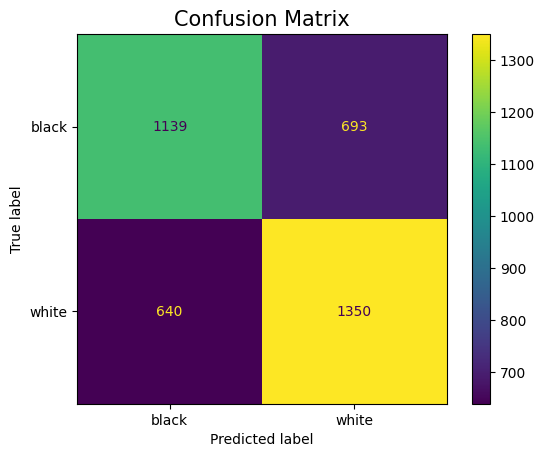

In [37]:
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['black', 'white'])
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()

**PCA Data Evalutation and Confusion Matrix**

In [38]:
train_accuracy_pca = clf_pca.score(X_train_pca, y_train_pca)
print("Train Score: " + str(train_accuracy_pca))
test_accuracy_pca = clf_pca.score(X_test_pca, y_test_pca)
print("Test Score: " + str(test_accuracy_pca))

y_pred_pca = clf_pca.predict(X_test_pca)

Train Score: 0.9990187099306554
Test Score: 0.5583464154892727


In [47]:
precision_pca = precision_score(y_test_pca, y_pred_pca)
print("Precision: " + str(precision_pca))
recall_pca = recall_score(y_test_pca, y_pred_pca, average='weighted')
print("Recall: " + str(recall_pca))
f1_pca = f1_score(y_test_pca, y_pred_pca, average='weighted')
print("F1 Score: " + str(f1_pca))
report_pca = classification_report(y_test_pca, y_pred_pca, target_names=['black', 'white'])
print("\nClassification Report:")
print(report_pca)

Precision: 0.571563981042654
Recall: 0.5583464154892727
F1 Score: 0.5573324335218609

Classification Report:
              precision    recall  f1-score   support

       black       0.54      0.51      0.52      1832
       white       0.57      0.61      0.59      1990

    accuracy                           0.56      3822
   macro avg       0.56      0.56      0.56      3822
weighted avg       0.56      0.56      0.56      3822



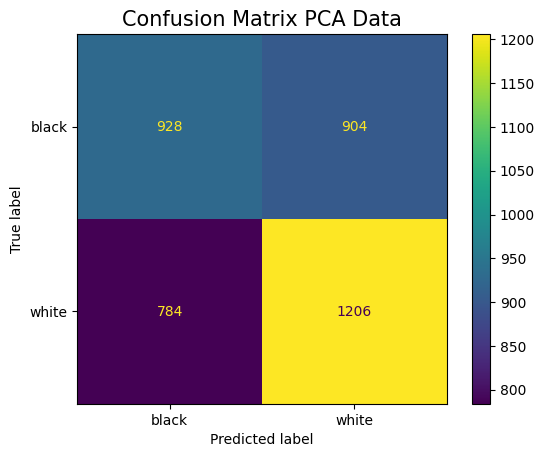

In [40]:
matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
display_pca = ConfusionMatrixDisplay(confusion_matrix=matrix_pca, display_labels=['black', 'white'])
display_pca.plot()
plt.title('Confusion Matrix PCA Data', fontsize=15)
plt.show()

**Evaluation and Confusion Matrix with Model Trained on Original Dataset with Best Hyperparameters**

In [41]:
train_accuracy_grid = clf_grid.score(X_train_grid, y_train_grid)
print("Train Score: " + str(train_accuracy_grid))
test_accuracy_best = clf_grid.score(X_test_grid, y_test_grid)
print("Test Score: " + str(test_accuracy_best))

y_pred_grid = clf_grid.predict(X_test_grid)

Train Score: 0.9504121418291247
Test Score: 0.6596023024594453


In [49]:
precision_grid = precision_score(y_test_grid, y_pred_grid)
print("Precision: " + str(precision_grid))
recalll_grid = recall_score(y_test_grid, y_pred_grid, average='weighted')
print("Recall: " + str(recall))
f1_grid = f1_score(y_test_grid, y_pred_grid, average='weighted')
print("F1 Score: " + str(f1_grid))
report_grid = classification_report(y_test_grid, y_pred_grid, target_names=['black', 'white'])
print("\nClassification Report: ")
print(report_grid)

Precision: 0.6631927996210327
Recall: 0.651229722658294
F1 Score: 0.6588114139501015

Classification Report: 
              precision    recall  f1-score   support

       black       0.66      0.61      0.63      1832
       white       0.66      0.70      0.68      1990

    accuracy                           0.66      3822
   macro avg       0.66      0.66      0.66      3822
weighted avg       0.66      0.66      0.66      3822



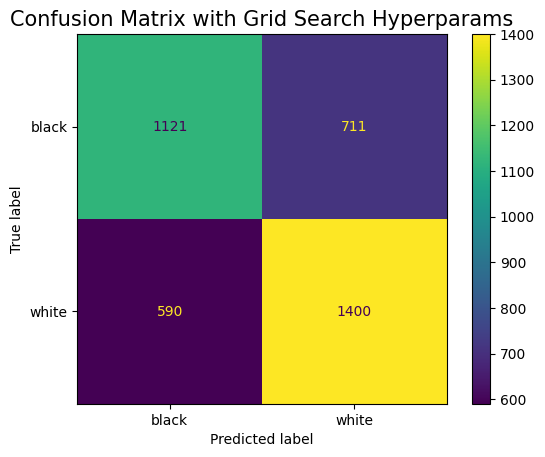

In [43]:
matrix_grid = confusion_matrix(y_test_grid, y_pred_grid)
display_grid = ConfusionMatrixDisplay(confusion_matrix=matrix_grid, display_labels=['black', 'white'])
display_grid.plot()
plt.title('Confusion Matrix with Grid Search Hyperparams', fontsize=15)
plt.show()